# Kaggle Challenge: Plant Classification (Team: The Great Botanist)

Arno Clognier

Hossein Firoz

Arturo Pinar

Akos Tanczos

# 1. Loading Needed libraries

In [ ]:
import numpy as np
import pandas as pd
import random 

#Import Pytorch
import torch
import torchvision
from torch import optim

#Little commonly used shortcut
import torch.nn as nn

from IPython.display import display

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

from torchvision import datasets, transforms, models

!pip install torchsummary
from torchsummary import summary

import os
import glob

from torch.utils.data import Dataset, DataLoader
from skimage import io, transform
from PIL import Image

In [ ]:
root_path = "/kaggle/input/polytech-nice-data-science-course-2021/polytech/"

# 2. Data Loading and Preprocessing
## 2.1. Data Augmentation

Here we defined severel augmantations:
1. Dataset: It's used to load the data. The smalles size of train images is 505x505 and all of them are rectangular. Therefore we are using a simple resize to load all the data, both for training and testing. ToTensor() function would normalized the data which is beneficial for learning process.
2. Training: The pre-traind models that we used (explained later) are very complex. If we only use the raw images, the models would overfitted easily. Therefore we used random crop of the raw image and random filip as well. We have tried to make the images Gray Style as well, but we didn't see any improvements.
3. Validation: For validation, we only resize the image according to the network we are using. The defualt value is based on our best model which is Resnet50.
4. Testing: For testing, we simply resize the image as well and call .ToTensor(). 

In [ ]:
img_transform= {
    'dataset':
    transforms.Compose([
        transforms.Resize(size=505), # Mean size of images is 505
        transforms.ToTensor(),
    ]),
    'training':
    transforms.Compose([
         transforms.RandomResizedCrop(size=224),
         transforms.RandomHorizontalFlip(),
    ]),
    'validation': 
    transforms.Compose([
        transforms.Resize(size=224),
    ]),
    'testing': 
    transforms.Compose([
        transforms.Resize(size=224),
        transforms.ToTensor(),
    ]),
}

## 2.2. Data Loading

For loading the traing images, we used PyTorch ImageFolder which automatically label each image in every subfolder. However, the label is not corresponding the the subfolder name, we have to address this issue when we are submitting the file (See submittin section).

In [ ]:
train_dataset = datasets.ImageFolder(root_path + "/train/", transform=img_transform['dataset'])

print('#{} images loaded succesfully!'.format(len(train_dataset)))

The stucture of the test folder is not the same: there are no subfolders and therefore we cannot use the same ImageFolder function. Reading the files manually would also be slow.
Here we inherit a Dataset class from PyTorch which reads image names from the sample_submission.csv file, load the image and apply the data augmantation. Using this custom dataset will enable us to read data in parallel.

In [ ]:
class TestDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with test image names.
            root_dir (string): Directory with all the test images.
            transform (callable, optional): Optional transform to be applied on images.
        """
        self.image_names = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.image_names.iloc[idx, 0])
        image = io.imread(img_name)
        if self.transform:
            image = self.transform(transforms.ToPILImage()(image))

        return image

In [ ]:
test_dataset = TestDataset(root_path + "sample_submission.csv", root_path + "/test/", img_transform['testing'])

print('#{} test images loaded succesfully!'.format(len(test_dataset)))

## 2.3. Checking Data Augmentation Result

Train Dataset is imbalanced. Here we can see the number of images for each class. We tried to balance the data by using augmantation for the classes with less images. However this process was slow, and we didn't see much improvements in our results. Therefore we use augmantation on all the data we have before feed-forwarding it to the network.

In [ ]:
#Get only the label for each image as a list
labels = [x[1] for x in tqdm(train_dataset)]

#Use the "count" method from Python lists
for x in range(153):
  print("Number of", x, ":", labels.count(x))

## 2.4. Showing some examples

This code show some random examples from the training dataset loaded above. 

In [ ]:
for i in range(10):
  n = random.randrange(len(train_dataset))
  print("Label = ", train_dataset[n][1], ":")
  display(transforms.ToPILImage()(train_dataset[n][0]))

## 2.5. Dataset split into training and validation sets

In [ ]:
SPLIT_SIZE = .1
n_val = round(SPLIT_SIZE * len(train_dataset))

train_set, val_set = torch.utils.data.random_split(train_dataset, [len(train_dataset)-n_val, n_val])

print('Spliting train images to #{} training samples and #{} samples for validation'.format(len(train_set), len(val_set)))

## 2.6. Creating Data Loaders

In [ ]:
BATCH_SIZE = 32

training_imagesB = {x: DataLoader(y, batch_size=BATCH_SIZE, shuffle=True) for x, y in zip(['training', 'validation'], [train_set, val_set])}

test_setB = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 3. Declaring Auxiliar functions
## 3.1. Main Training Loop

This is the main training loop. This function is generalized and we used the same function for running multiple experiments.
To make the function general, we define a "mode" which indicated either the training or validation phase. Based on each phase, we put model to train() or eval() mode. This is neccessary as we are using dropout layers and in eval() the dropouts are considered normal layers and all the neural are activated.

Before forwarding the images to the network, we transfer them to GPU for faster batch processing. Also, we would apply data augmantation before passing them to the network.

To have a better convergence, we use learning-rate-decay as well. We use the standard rate of 1/10th for learning rate in selected epochs. Although both the learning-rate-decay and the schedule can be optimized as a hyperparamerts, we find the defult values by running multiple experiments. Therefore these numbers are handcrafted.

In [ ]:
from torch import optim

    
def train(network,optim, N_EPOCHS=80,  learning_rate=0.1, momentum=0.9, lr_schedule=None):
    
    modes = ['training', 'validation']
    
    best_net = None
    net = network
    
    net = net.cuda()

    criterion = nn.CrossEntropyLoss()
    optimizer = None
    
    if optim == "SGD":
        optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum, nesterov=True)
  
    if optim == "Adam":
        optimizer = torch.optim.Adam(network.parameters(), lr = learning_rate)
    
        
    epoch_loss_history, epoch_acc_history = {'training': [], 'validation': []}, {'training': [], 'validation': []}

    best_running_acc = 0


    for e in range(N_EPOCHS):
        print("EPOCH:",e)
        
        for mode in modes: 
            
            running_loss = 0
            running_accuracy = 0
            
            if mode == 'training':
                model.train()
            else:
                model.eval()

            for images, labels in tqdm(training_imagesB[mode]):
                images = img_transform[mode](images).cuda()
                labels = labels.cuda()
                y = net(images)
                loss = criterion(y, labels)

                if mode == 'training':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                running_loss += loss.item()
                running_accuracy += (y.max(1)[1] == labels).sum().item()

            epoch_loss = running_loss / len(training_imagesB[mode].dataset)
            epoch_acc = running_accuracy / len(training_imagesB[mode].dataset)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(mode, epoch_loss, epoch_acc))

            epoch_loss_history[mode].append(epoch_loss)
            epoch_acc_history[mode].append(epoch_acc)

            if mode == 'training':
                if lr_schedule is not None and e in lr_schedule:
                    for param_group in optimizer.param_groups:
                        param_group['lr'] /= 10
                    print('Switching lr to {}'.format(optimizer.param_groups[0]['lr']))
    
            else:
                if running_accuracy > best_running_acc:
                    best_running_acc = running_accuracy
                    best_net = net
    
    return best_net, epoch_loss_history, epoch_acc_history

## 3.2. Plot accuracy and loss of each epoch function

In [ ]:
def plot_epoch_history(loss_history, acc_history, epochs):
    epochs_list = []
    for i in range(epochs): 
        epochs_list.append(i)

    epoch_acc = acc_history["training"]
    epoch_val_acc = acc_history["validation"]
    plt.plot(epochs_list, epoch_acc, label = "Training Accuracy")
    plt.plot(epochs_list, epoch_val_acc, label = "Validation Accuracy")
    plt.title('accuracy')
    plt.xlabel('epoch')
    plt.legend()

    plt.show()
    
    epoch_loss = loss_history["training"]
    epoch_val_loss = loss_history["validation"]
    plt.plot(epochs_list, epoch_loss, label = "Training Loss")
    plt.plot(epochs_list, epoch_val_loss, label = "Validation Loss")
    plt.title('loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

## 3.3. Plot Confusion Matrix

In [ ]:
def print_confusion_matrix(net):
    df_confusion = None
    for images, labels in training_imagesB["validation"]:
        images = img_transform["validation"](images).cuda()
        labels = labels.cuda()
        y = net(images)
        print("pred: ", y.max(1)[1])
        print("labels: ", labels)
        pred = y.max(1)[1].cpu()
        labels = labels.cpu()
                
        y_true = pd.Series(labels, name = "Real")
        y_pred = pd.Series(pred, name = "Predicted")
        df_confusion = pd.crosstab(y_true, y_pred)
        break
                
    return df_confusion

## 3.4. Generate Submission File

As we discussed in section 2, the ImageFolder would not return the image labels based on the subfolder name. It would label each subfolder in an increasing numbers starting from 0.
Therefore, to create the correct submissionm we used "class_to_idx" which returns a dictionary from the class_number of the subfoler name. We use this dictionary to translate the network output to actual labels.

Again, by using the power of parrallel computing of GPU, we are updating the predicted labels based for BATCH_SIZE at each step instead of doing it image by image. We would change #BATCH_SIZE of lables in the sample_submission file in each iteration.

In [ ]:
def generate_submission_file(net):
    class_dict = dict((v,int(k)) for k,v in train_dataset.class_to_idx.items())

    sample_submission = pd.read_csv(root_path + "sample_submission.csv")
    net.eval()

    predictions = []
    for i, images in enumerate(tqdm(test_setB)):
        x = images.cuda()
        prediction = net(x).max(1)[1].cpu()
        prediction_class = prediction.apply_(lambda x: class_dict[x]).numpy()
        no_prediction = len(prediction_class)
        sample_submission.loc[i*BATCH_SIZE:i*BATCH_SIZE+no_prediction-1, 'class'] = prediction_class
        predictions.append(prediction_class)
    sample_submission.to_csv('submission.csv', sep=',',index = False)
    return predictions
    

## 3.5. Display some predicted images

In [ ]:
def display_predictions(predictions):
    for p in range(11):
        display(transforms.ToPILImage()(test_dataset[p]))
        print("Class predicted: ", predictions[0][p]) # first batch

# 4. Experiment 1: GoogleNet

## 4.1. Motivation

One of the main problems in Deep Learning field for image classification is that large networks are prone to overfitting and suffer from either exploding and vanishing gradient problem. (https://towardsdatascience.com/deep-learning-googlenet-explained-de8861c82765)

However, the GoogLeNet architecture offer a posible solution of these problems by using an Inception module (that uses dimensional reduction). 

The GoogleNet architecture consists of 27 layers (including Pooling layers) in which 9 are inception modules. 

## 4.2. Design

In the following code the design of the GoogleNet model is explained. Precisely, we have chosen the learning rate performing a comparison between different typical values for learning rate and getting the best as the one with the highest validation accuracy. 

Moreover, the common optimizer used for GoogleNet is the SGD (https://www.analyticsvidhya.com/blog/2018/10/understanding-inception-network-from-scratch/), however, since Adam in the majority of cases is the fastest optimizer (https://towardsdatascience.com/optimizers-for-training-neural-network-59450d71caf6) we have performed some experiments with both for optimize GoogleNet that yield to the conclusion that Adam give the best validation accuracy. 

Finally, the learning rate schedule used was [1,0.3,0.3] since it was the one recommended by the literature (https://www.analyticsvidhya.com/blog/2018/10/understanding-inception-network-from-scratch/)

In [ ]:
model = torchvision.models.googlenet(pretrained = True)
lr = 0.003
optim = "Adam"
epochs = 11
net, loss, acc = train(model, optim, N_EPOCHS = epochs, learning_rate = lr, lr_schedule = [1,0.3,0.3])


## 4.3. Results

In [ ]:
plot_epoch_history(loss, acc, epochs)


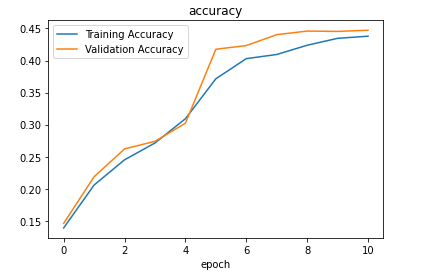

According to the accuracy plot we can see that the accuracy grows very fast from the first epoch what means the model learn fast, however, from epoch 8 the accuracy stabilize in 45% what is a bad accuracy, therefore, we perform other experiments with different models. 

In [ ]:
print_confusion_matrix(net)

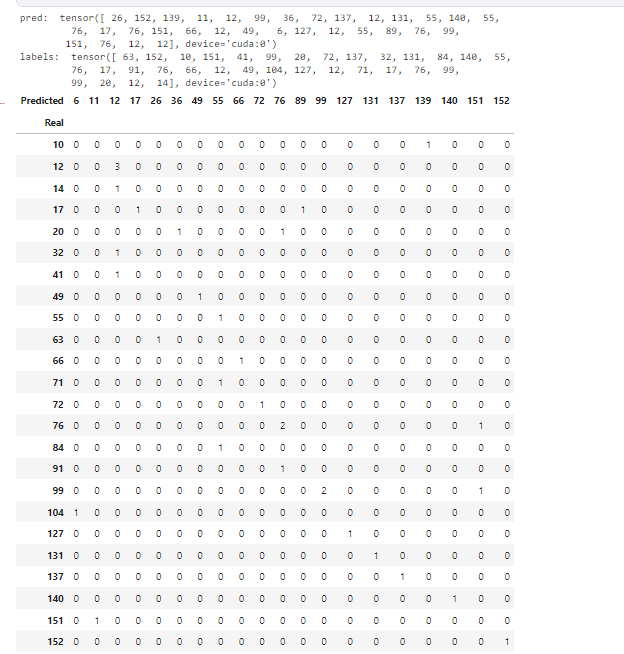

The confusion matrix gives a more detailed analysis of which predictions were good or not. 

Since the provided test set does not have the classes (labels) for each image, we have used the validation set for plotting the confusion matrix, hence, it represents the predicted row that corresponds with the predictions of the model for each image of the batch in the validation set and the real labels associated with each image of the batch. 

Moreover, in order to check the relation between the predictions of the model and the real labels associated with each image we have printed both as "pred" corresponding to the predictions and "labels" correspoding to the ground truth (the labels). 

Then, analyzing the first one: predicted value = 26 but the real class of the image is 63 we can see that going to the column 26 and row 63 there is a 1 that means that one prediction was 26 but the real value 63. 


In [ ]:
predictions = generate_submission_file(net)
display_predictions(predictions)


Finally the predictions are generated over the images of the test set. Since the test set does not contain labels is imposible to compare them with the ground truth. 

## 4.4. Conclusions & Insights

In conclusion, this experiment shows a potential way to avoid overfitting and vanishing gradient problem present in large network by using Inception blocks implemented in the model GoogleNet. 

By trial and error we have concluded the best way to run the experiment is by using the optimizer Adam, learning rate = 0.003 and learning rate decay. 

However, the results of the experiment show the model stabilizes in a certain value of accuracy that is not enough for our goal, therefore, we have performed other experiments with different models. 

# 5. Experiment 2: VGG16

## 5.1. Motivation

By considering the literature (https://neurohive.io/en/popular-networks/vgg16/) we wanted to try a different model to outperform GoogleNet since as shown in Experiment 1, the accuracy stabilize in a constant value below the 50%. 

One posible solution is the VGG16 model that is described in the following image: 


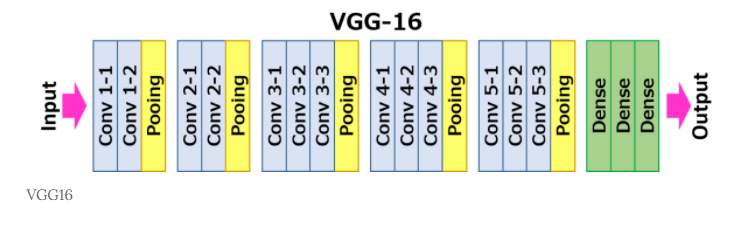

The main reason for trying this model was that it outperformed the previous generation of models in the ILSVRC-2013, winning GoogleLeNet by 0.9%. 

## 5.2. Design

In [ ]:
model = torchvision.models.vgg16(pretrained = True)

summary(model.cuda(), (3, 256, 256))

We have implemented VGG16 freezing all the parameters of the different layers except for the last 3 (the linear fully connected ones). 

The rationale behind this decision was that VGG has a huge number of parameters (138.357.544 parameters) that with a not very large batch of images tends to easily overfit. Therefore, since the greatest number of parameters come from the last 6 layers (classifiers) we have decided (by trial and error) to freeze every layer except the last 3. Moreover, if we freeze all the layers except the last one the problem of overfitting could be solved but since the model has a small number of parameters to learn this could yield in the model not learning all the essential features of the images (underfitting). 

In [ ]:
# Freeze model weights
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the last 3 Linear Layers
model.classifier[0].requires_grad = True
model.classifier[3].requires_grad = True

# Unfreeze the last layer and add structure for output the 153 classes
model.classifier[6] = nn.Sequential(
                      nn.Linear(4096, 256), 
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(256, 153),                   
                      nn.LogSoftmax(dim=1))

As in the experiment 1 we have concluded by trial and error that the best optimizer is Adam. Moreover, we have tried to reduce the learning rate of the experiment 1 to the half what gave us better results.

In [ ]:
# Train the model
learn_rate = 0.0015
optim = "Adam"
epochs = 11
net, loss, acc = train(model, optim, N_EPOCHS = epochs, learning_rate = learn_rate, lr_schedule = [4,7,9,10])

## 5.3. Results

In [ ]:
plot_epoch_history(loss, acc, epochs)

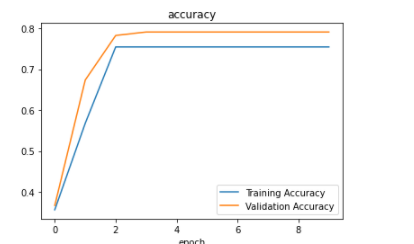


| Epoch      | Training accuracy | Validation Accuracy
| ----------- | ----------- | ----------------------
| 0      |      0.3567       | 0.3674
| 1   | 0.5678        | 0.6734
| 2      |      0.7543       | 0.7822
| 3   | 0.7543        | 0.7907
| 4      |      0.7543       | 0.7907
| 5   | 0.7543       | 0.7907
| 6      |      0.7543       | 0.7907
| 7   | 0.7543        | 0.7907
| 8      |      0.7543       | 0.7907
| 9   | 0.7543       | 0.7907
| 10   | 0.7543        | 0.7907

As it can be seen in the accuracy plot, the VGG16 overcomes the GoogleNet model reaching a training and validation accuracy that approximately equals the double of the ones of the GoogleNet. 

However, the model reaches a maximum point between 0.79 and 0.8 where it stabilizes. Therefore, we have performed more experiments to reach a better result.

In [ ]:
print_confusion_matrix(net)

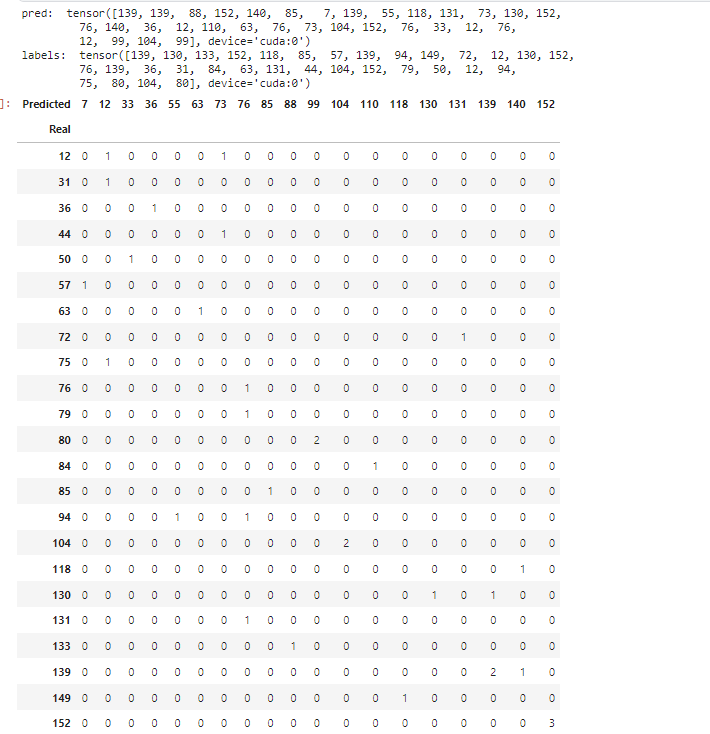

The confusion matrix gives a more detailed analysis of which predictions were good or not. 

Since the provided test set does not have the classes (labels) for each image, we have used the validation set for plotting the confusion matrix, hence, it represents the predicted row that corresponds with the predictions of the model for each image of the batch in the validation set and the real labels associated with each image of the batch. 

Moreover, in order to check the relation between the predictions of the model and the real labels associated with each image we have printed both as "pred" corresponding to the predictions and "labels" correspoding to the ground truth (the labels). 

In this case more results are correct predicted than in the case of GoogleNet since the accuracy obtained is much higher. 


In [ ]:
predictions = generate_submission_file(net)
display_predictions(predictions)

Finally the predictions are generated over the images of the test set. Since the test set does not contain labels is imposible to compare them with the ground truth. 

## 5.4. Conclusions & Insights

In conclusion, this experiment was intended to overcome the limitations presented by GoogleNet.

For this purpose we have used the VGG16 model where we have freezed all the model except the last 3 layers (fully connected ones) to reach a balance between underfitting and overfitting. 

The results are much better than the ones obtained by GoogleNet, however it still exist a maximum point where the accuracy stabilizes. In order to overcome this limitation we have performed more experiments with different models. 

# 6. Experiment 3: Resnet 101

## 6.1. Motivation

As it can be seen in the 2 previous experiments, deeper networks tends to converge yielding a degradation problem: When the network depth increases the accuracy gets saturated and then degrades rapidly (https://neurohive.io/en/popular-networks/resnet/). This phenomenom can be seen in the previous experiments where the accuracy reaches a maximum point and becomes constant (it will degrade too but are needed more epochs for that phenomenom to become visible). 

One posible solution is the introduction of Resnet that using a shortcut connections allow to add identity mapping to the outputs of the other layers. The main advantage is that they facilitate the optimization of the network and they can easily gain accuracy from greatly increased depth (that before provokes the saturation of the accuracy). 

Moreover, we choose the architecture of Resnet101 since they outperform VGG16 in Faster R-CNN. (https://medium.com/@14prakash/understanding-and-implementing-architectures-of-resnet-and-resnext-for-state-of-the-art-image-cf51669e1624)


## 6.2. Design

Being a large network with a great chance of overfitting on our data, we have added a dropout layer of 0.4 which allows a better generalization of the model. 

In [ ]:
model = models.resnet101(pretrained = True)

model.fc = nn.Sequential(
                        nn.Linear(2048, 512), 
                        nn.ReLU(),
                        nn.Dropout(0.4),
                        nn.Linear(512, 153),
                        nn.LogSoftmax(dim = 1))

summary(model.cuda(), (3,256, 256))


    


In [ ]:
learning_rate = 0.0015

optim = "Adam"
epochs = 11

net, loss, acc = train(model, optim, N_EPOCHS = epochs, learning_rate = lr, lr_schedule = [4,7,9,10])

## 6.3. Results

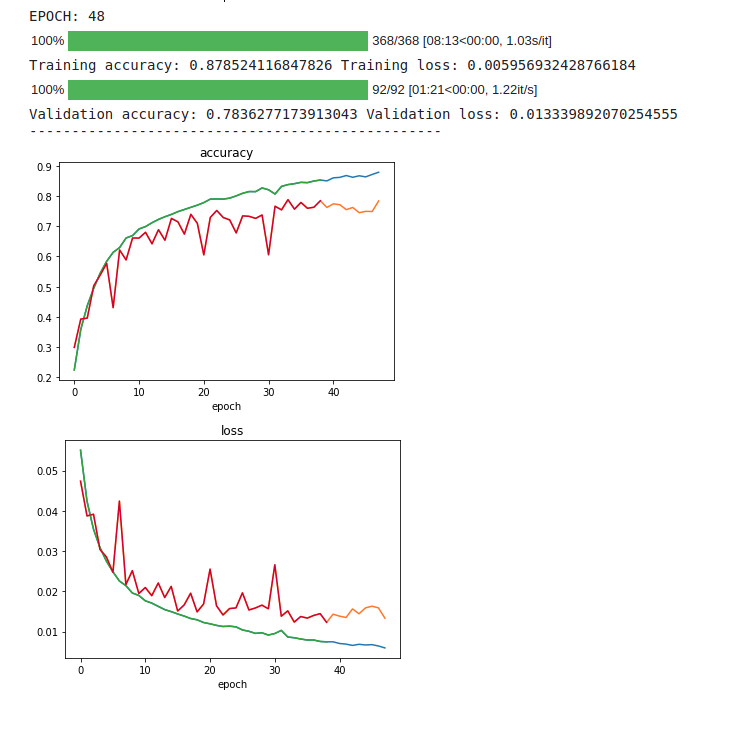

## 6.4. Conclusions & Insights

Despite the dropout added, we observe overfitting and fluctuations because of little epochs.

In order to improve that result we performed the Experiment 4: Resnet50. 

# 7. Experiment 4: Resnet50

Resnet50 with more than 23M paramenters is our best model. We used simple Stochastic Gradient Decent for the optimizer as we are doing the lr-rate decay manually.

Resnet50 was chosen because by normalizing the image pixel values to [0, 1] by calling ToTensor() in our augmantation, residual links would help the gradient to reach the first layers of the network to avoid vanishing gradients.
In addition, as the resent50 was trained using ImageNet, using the pretrained model would be beneficial for this classification as ImageNet has plants images as well. Using pretrained model would reduce the training time as the first layers are already trained on how to recognize the shape/edges/colors etc.

We tried freezing the first layer and only train the last layers which are responsible for classification, but the training wasn't succesful and model would underfitted based on the number of parameters.

We also got some ideas from this github repository: https://github.com/plantnet/PlantNet-300K where they used resnet50 for the PlantNet dataset. Some of the hyperparamerts for training was borrowed from this repository.

## 7.1. Motivation



Resnet50 with more than 23M paramenters is our best model. We used simple Stochastic Gradient Decent for the optimizer as we are doing the lr-rate decay manually.

Resnet50 was chosen because by normalizing the image pixel values to [0, 1] by calling ToTensor() in our augmantation, residual links would help the gradient to reach the first layers of the network to avoid vanishing gradients.
In addition, as the resnet50 was trained using ImageNet, using the pretrained model would be beneficial for this classification as ImageNet has plants images as well. Using pretrained model would reduce the training time as the first layers are already trained on how to recognize the shape/edges/colors etc.

We tried freezing the first layer and only train the last layers which are responsible for classification, but the training wasn't succesful and model would underfitted based on the number of parameters.

We also got some ideas from this github repository: https://github.com/plantnet/PlantNet-300K where they used resnet50 for the PlantNet dataset. Some of the hyperparamerts for training was borrowed from this repository.

## 7.2. Design

Resnet50 was originally trained on 224x224 images.

In [ ]:
model = models.resnet50(pretrained=True)

model.fc = nn.Linear(2048, 153)

summary(model.cuda(), (3, 224, 224))

In [ ]:
optim = "SGD"
epochs = 11
net, loss, acc = train(model, optim, N_EPOCHS=epochs,  learning_rate=0.1, momentum=0.9, lr_schedule=[4, 7, 9, 10])


## 7.3. Results

In [ ]:
plot_epoch_history(loss, acc, epochs)

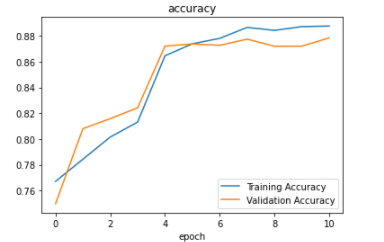

| Epoch      | Training accuracy | Validation Accuracy
| ----------- | ----------- | ----------------------
| 0      |      0.7671       | 0.7498
| 1   | 0.7843        | 0.8080
| 2      |      0.8015       | 0.8158
| 3   | 0.8131        | 0.8242
| 4      |      0.8645       | 0.8720
| 5   | 0.8738        | 0.8737
| 6      |      0.8780       | 0.8726
| 7   | 0.8865        | 0.8774
| 8      |      0.8842       | 0.8719
| 9   | 0.8871        | 0.8720
| 10   | 0.8876        | 0.8784


Based on the above table, we can see the training accuracy and validation accuracy are increasing in each epoch. As both the values are close together, we can argue model is not overfitted.
However, training it for longer epochs would cause the model to overfit. There are two main approches to tackle this issue:
1. Increase Image Size: We do not have access to more images, but using larger images like 300x300 instead of 224x224, would increase the data that we are learning from and it would help our model to avoid overfitting. However it would create 80% overhead for training loop. Also we need to adopt the learning-rate as well.
2. FineTuning: After 10 epochs, we can use a simpler augmentation (like resize only) for finetuning the model. However the learning-rate should be really small.

In [ ]:
predictions = generate_submission_file(net)
display_predictions(predictions)

## 7.4. Conclusions & Insights

In this exercise, we used different model to train a large classifier. We learned how to use pre-trained model and how beneficial they are, we learned how to load/work with large datasets as well.
With couple of models getting overfitted/underfitted, we learned the beneficial of using data augmantation too.

# 8. Final Remarks

This project was devoted to develop an experiment able to find the best accuracy classifying the images of the Pl@ntNet Dataset (https://plantnet.org/en/) into the different 153 classes of plants. 

The main goal is to provide a framework able to classify a new plant (from a photo taken by a mobile, a photo from Internet, etc) into the correct class of plant that corresponds with its scientific name. 

To this aim we have performed 4 different experiments: GoogleNet, VGG16, ResNet101 and Resnet50. 

The first one (GoogleNet), tried to overcome the limitations produced in large deep neural networks by using inception blocks, however, it showed that it stabilizes in a low accuracy (45%). 

The second one (VGG16), tried to overcome the limitations presented in GoogleNet by using the VGG16 model with all the layers freezed except the last 3 (to find the best balance between underfitting and overfitting). However, it presented a saturation in the accuracy over 78%. 

The third one (Resnet101), overcome the limitation of the saturation of the accuracy by using residual links, however, in the event of a high number of epochs it presented overfitting. 

Finally, the fourth one (Resnet50), overcome the problem of overfitting and was trained with a similar dataset (ImageNet). 

As future development, we consider that there are many directions to continue this project: 
-  Overcome the limitation presented by Resnet50. There are two main approches to tackle this issue:
    - Increase Image Size: We do not have access to more images, but using larger images like 300x300 instead of 224x224, would increase the data that we are learning from and it would help our model to avoid overfitting. However it would create 80% overhead for training loop. Also we need to adopt the learning-rate as well.
    - FineTuning: After 10 epochs, we can use a simpler augmentation (like resize only) for finetuning the model. However the learning-rate should be really small.
    - Exploring different datasets that can many potential applications as recognition of cars, people, animals, etc